In [56]:
import numpy as np
import matplotlib.pyplot as plt

from argosim.antenna_utils import *
from argosim.plot_utils import *
from argosim.data_utils import *
from argosim.clean import *
from argosim.imaging_utils import *
from argosim.beam_utils import *
from argosim.metrics_utils import *

In [57]:
def plot_antenna_arr_(array, ax=None, fig=None, title="Array", axis_label=True):
    """Plot antenna array.

    Function to plot the antenna array in ground coordinates.

    Parameters
    ----------
    array : np.ndarray
        The antenna array positions in the ground.
    ax : matplotlib.axes.Axes
        The axis to plot the antenna array. For plotting on a specific subplot axis.
    fig : matplotlib.figure.Figure
        The figure to plot the antenna array. For plotting on a specific subplot axis.
    title : str
        The title of the plot.

    Returns
    -------
    None
    """
    # Center the array
    array = array - np.mean(array, axis=0)
    # Convert to km
    array = array / 1000.0
    if ax == None or fig == None:
        fig, ax = plt.subplots(1, 1)
    ax.scatter(array[:, 0], array[:, 1], s=45, c="mediumblue")
    for i, txt in enumerate(range(1, len(array) + 1, 1)):
        # ax.annotate(txt, (array[i, 0], array[i, 1]))
        ax.set_xlabel("E [km]")
        ax.set_ylabel("N [km]")
        x_lim = np.max(np.abs(array)) * 1.1
        y_lim = x_lim
        ax.set_xlim(-x_lim, x_lim)
        ax.set_ylim(-y_lim, y_lim)
        ax.set_aspect("equal", adjustable="box")
    ax.set_title(title)
    if ax == None or fig == None:
        plt.show()


def plot_baselines_(baselines, ax=None, fig=None, ENU=False):
    """Plot baselines.

    Function to plot the baselines in uv-space.

    Parameters
    ----------
    baselines : np.ndarray
        The uv-space sampling positions.
    ax : matplotlib.axes.Axes
        The axis to plot the baselines. For plotting on a specific subplot axis.
    fig : matplotlib.figure.Figure
        The figure to plot the baselines. For plotting on a specific subplot axis.
    ENU : bool
        If True, plot the baselines in East-North-Up coordinates. Otherwise, plot in uv-space.

    Returns
    -------
    None
    """
    if ax == None or fig == None:
        fig, ax = plt.subplots(1, 1)
    if ENU:
        ax.set_xlabel("East [m]")
        ax.set_ylabel("North [m]")
        ax.set_title("Baselines")
        ax.scatter(baselines[:, 0], baselines[:, 1], s=2, c="darkred")
        ax.set_xlim([np.min(baselines), np.max(baselines)])
        ax.set_ylim([np.min(baselines), np.max(baselines)])
    else:
        ax.set_xlabel(r"$u$(k$\lambda$)")
        ax.set_ylabel(r"$v$(k$\lambda$)")
        ax.set_title(r"$uv$-plane")
        ax.scatter(baselines[:, 0] / 1000, baselines[:, 1] / 1000, s=2, c="darkred")
        ax.set_xlim([np.min(baselines) / 1000, np.max(baselines) / 1000])
        ax.set_ylim([np.min(baselines) / 1000, np.max(baselines) / 1000])
    ax.set_aspect("equal", adjustable="box")
    if ax == None or fig == None:
        plt.show()

In [58]:
antenna = load_antenna_enu_txt('../configs/arrays/argos_pathfinder.enu.txt')

In [59]:
baselines = get_baselines(antenna)

In [60]:
# Multiband parameters
bandwidth = 2000e6
n_freqs = 128
f = 2000e6 # 2 GHz, lambda = 0.15 m

# Source tracking parameters
source_decl = 90./180*np.pi
array_lat = 35./180*np.pi # Heraklion latitud
track_time = 5
delta_t = 15/60 # 900 segs
t_0 = -0.5
n_times = int(track_time/delta_t)

track, freqs = uv_track_multiband(baselines, array_lat, source_decl, track_time, t_0, n_times, f, bandwidth, n_freqs, multi_band=False)
#track, freqs = uv_track_multiband(baselines, array_lat, source_decl, track_time, t_0, n_times, f, bandwidth, n_freqs)

#track_plot = np.reshape(track, (-1, 3))
print('The tracking is done for {} frequency bands'.format(n_freqs))
print('The tracking is done for {} time samples'.format(n_times))

The tracking is done for 128 frequency bands
The tracking is done for 20 time samples


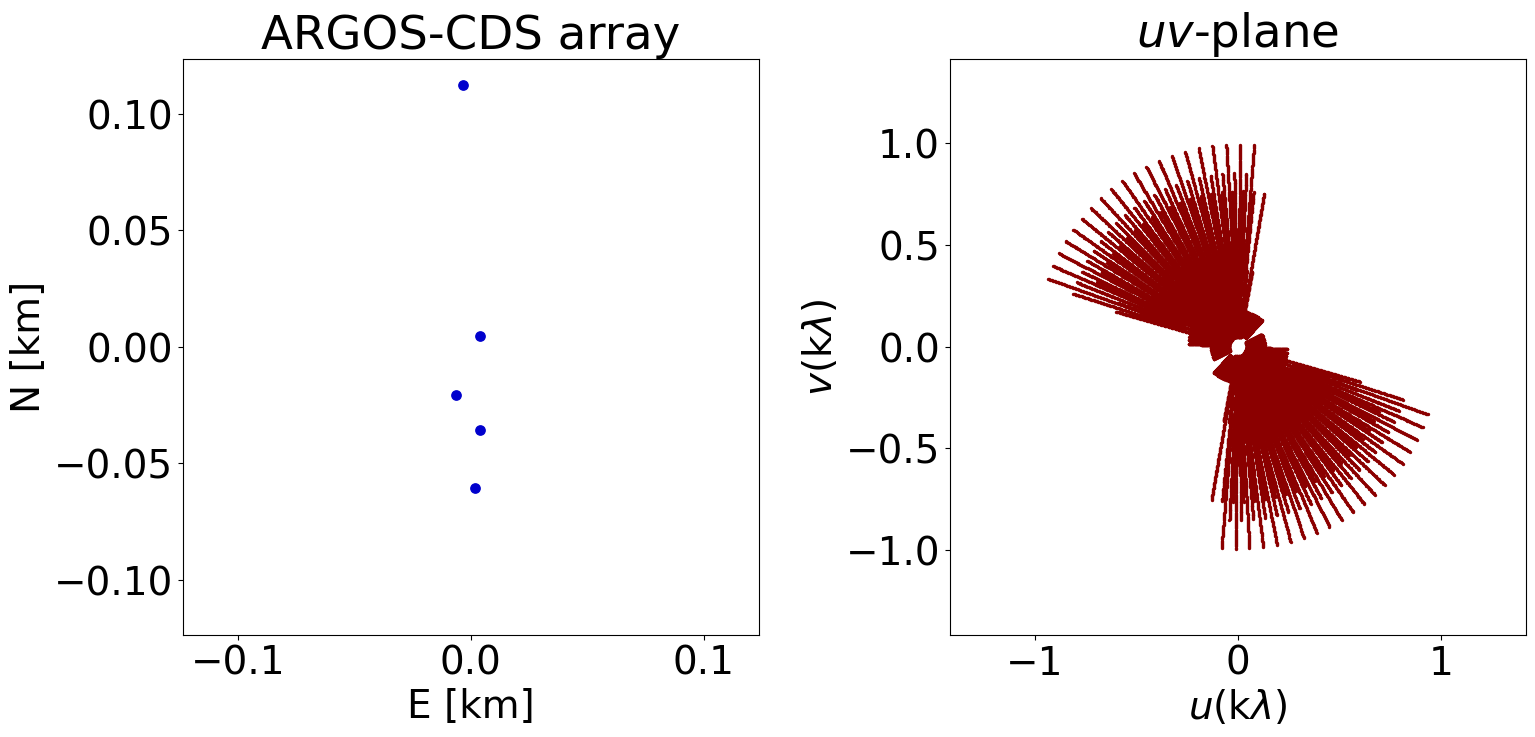

In [61]:
plt.rcParams.update({'font.size': 28})

fig, ax = plt.subplots(1,2, figsize=(16, 10))
plot_antenna_arr_(antenna, ax=ax[0], fig=fig, title='ARGOS-CDS array')
plot_baselines_(track, ax=ax[1], fig=fig)
plt.tight_layout()
plt.savefig('../figures/argos_CDS_array_baseline.pdf',dpi=300,bbox_inches='tight')

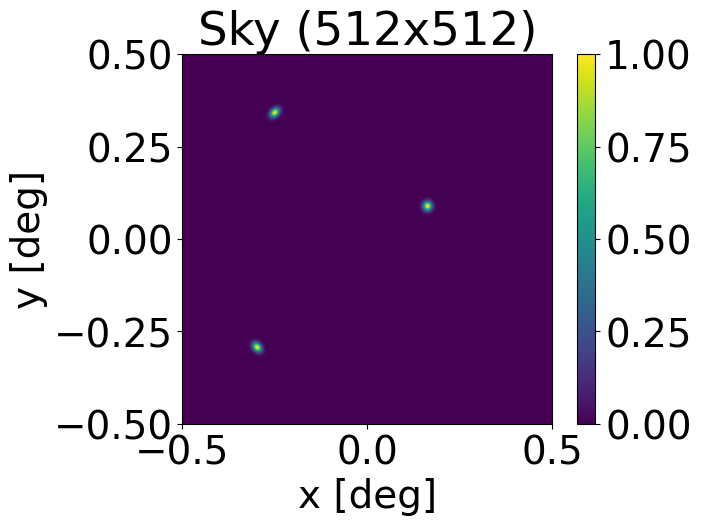

In [146]:
Npx = 512
fov_size = 1. # 3 degrees FOV from 6 m parabolic dishes.
sky = n_source_sky((Npx, Npx), fov_size, deg_size_list=[0.02, 0.02, 0.02], source_intensity_list=[.33]*3,seed=86, norm='max')
plot_sky(sky, (fov_size, fov_size))

# Single-band observation

In [147]:
observation_single, dirty_beam_single = simulate_dirty_observation(sky, track, fov_size, multi_band=False, sigma=0.2)

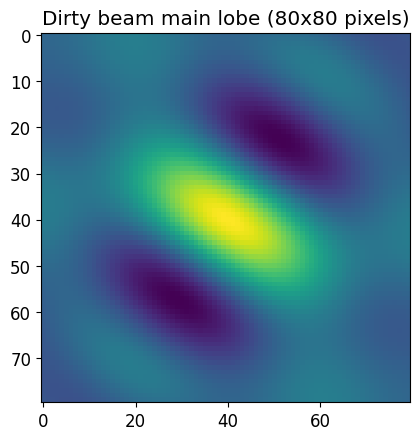

In [148]:
plt.rcParams.update({'font.size': 12})

main_lobe_px = 80
plt.imshow(dirty_beam_single[Npx//2-main_lobe_px//2:Npx//2+main_lobe_px//2,Npx//2-main_lobe_px//2:Npx//2+main_lobe_px//2])
plt.title('Dirty beam main lobe ({}x{} pixels)'.format(main_lobe_px, main_lobe_px))
plt.show()

In [168]:
I_clean_single, sky_model_single = clean_hogbom(observation_single, dirty_beam_single, 0.02, 400, 1e-3 , clean_beam_size_px=11)
I_clean_single = I_clean_single / np.max(I_clean_single)  # Normalize the image

Reached threshold at iteration 251


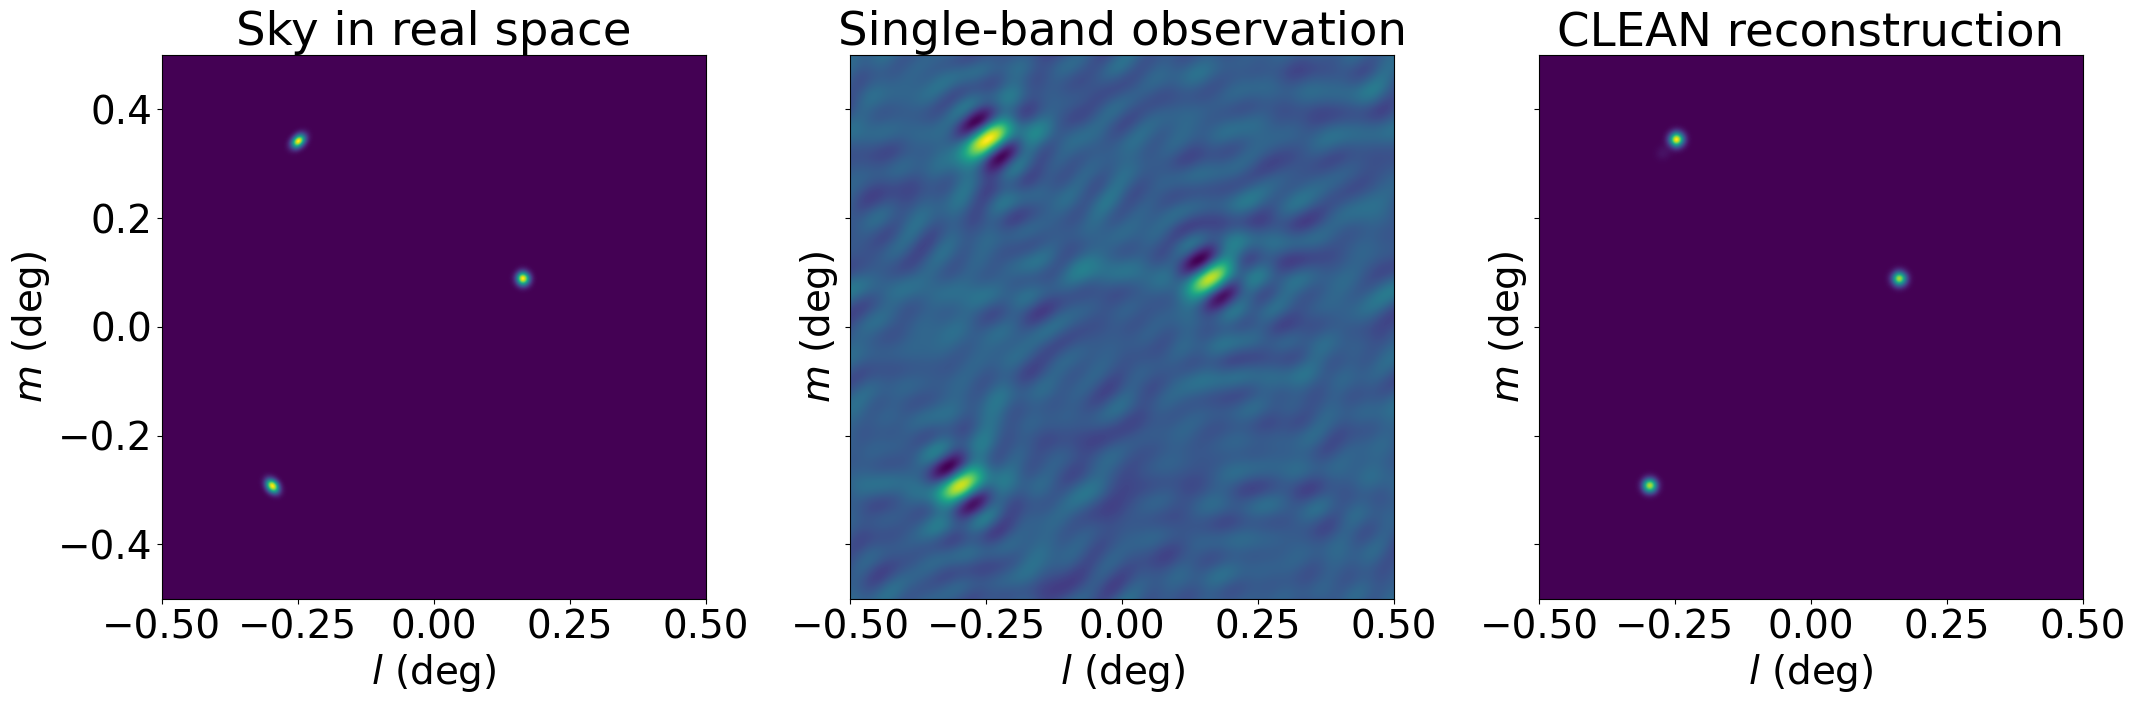

In [169]:
plt.rcParams.update({'font.size': 28})

fig, ax = plt.subplots(1,3, figsize=(22, 16), sharey='row')

ax[0].imshow(np.abs(sky), extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[0].set_xlabel(r"$l$ (deg)")
ax[0].set_ylabel(r"$m$ (deg)")
ax[0].set_title("Sky in real space")
#ax[0,0].set_yticks([-50, 0, 50])
ax[1].imshow(observation_single, extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[1].set_xlabel(r"$l$ (deg)")
ax[1].set_ylabel(r"$m$ (deg)")
ax[1].set_title("Single-band observation")
ax[2].imshow(I_clean_single, extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[2].set_xlabel(r"$l$ (deg)")
ax[2].set_ylabel(r"$m$ (deg)")
ax[2].set_title("CLEAN reconstruction")
plt.tight_layout()
#plt.savefig('../figures/argos_CDS_observation.pdf',dpi=300, bbox_inches='tight')
plt.show()

# Beam metrics

## Between single-band reconstruction and sky

In [176]:
from skimage.metrics import structural_similarity as ssim

In [187]:
metrics_single = compute_metrics(sky, I_clean_single)
print(metrics_single.keys())

print(metrics_single['mse'])
print(metrics_single['rel_mse'])
# Compute SSIM between sky and I_clean_single, using data_range for proper normalization
print(ssim(sky, I_clean_single, data_range=I_clean_single.max() - I_clean_single.min()))

print('#' * 50)
# compute metrics with the observation
metrics_single_obs = compute_metrics(sky, observation_single)
print(metrics_single_obs.keys())
print(metrics_single_obs['mse'])
print(metrics_single_obs['rel_mse'])
print(ssim(sky, observation_single, data_range=observation_single.max() - observation_single.min()))


dict_keys(['mse', 'rel_mse', 'residual'])
3.8888293225302855e-05
0.05702958084013284
0.9977748038964998
##################################################
dict_keys(['mse', 'rel_mse', 'residual'])
0.0005524894209147499
0.810224298372522
0.2537591917368328


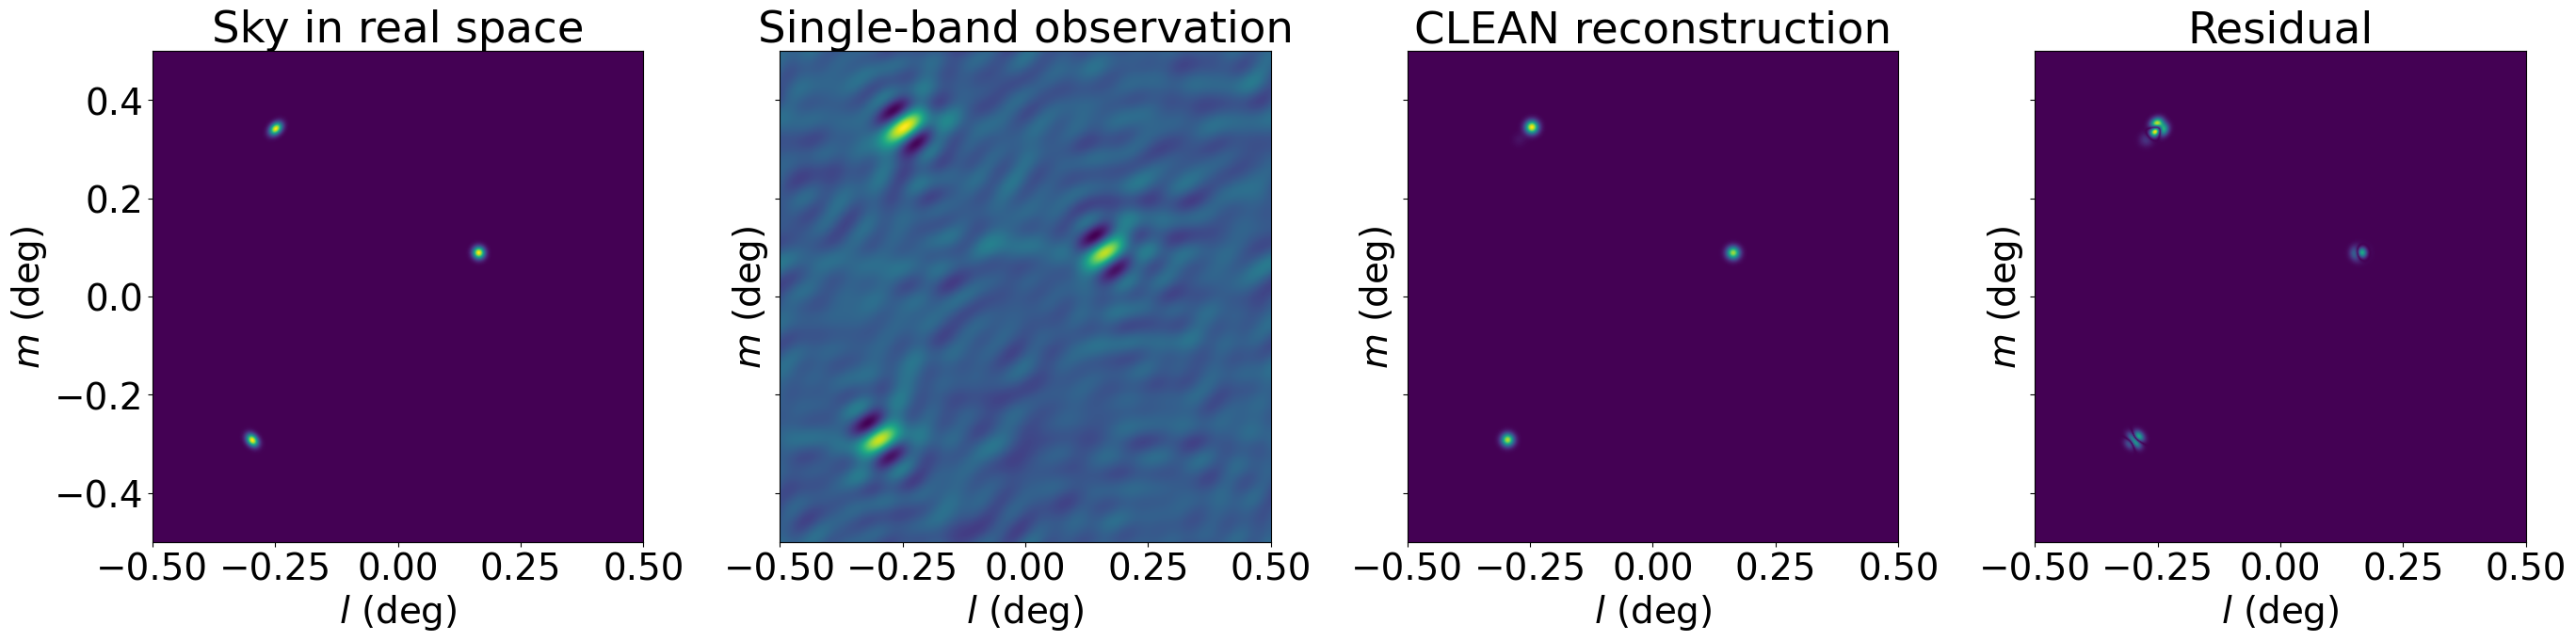

In [171]:
plt.rcParams.update({'font.size': 28})

fig, ax = plt.subplots(1,4, figsize=(28, 20), sharey='row')

ax[0].imshow(np.abs(sky), extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[0].set_xlabel(r"$l$ (deg)")
ax[0].set_ylabel(r"$m$ (deg)")
ax[0].set_title("Sky in real space")
#ax[0,0].set_yticks([-50, 0, 50])
ax[1].imshow(observation_single, extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[1].set_xlabel(r"$l$ (deg)")
ax[1].set_ylabel(r"$m$ (deg)")
ax[1].set_title("Single-band observation")
ax[2].imshow(I_clean_single, extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[2].set_xlabel(r"$l$ (deg)")
ax[2].set_ylabel(r"$m$ (deg)")
ax[2].set_title("CLEAN reconstruction")
ax[3].imshow(metrics_single['residual'], extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[3].set_xlabel(r"$l$ (deg)")
ax[3].set_ylabel(r"$m$ (deg)")
ax[3].set_title("Residual")
plt.tight_layout()
plt.savefig('../figures/argos_CDS_observation.pdf',dpi=300, bbox_inches='tight')
plt.show()

In [172]:
compute_beam_metrics(dirty_beam_single)

{'sll_db': -3.391129348330642,
 'fwhm': (19.631329428078143, 8.146834040673287),
 'eccentricity': 0.909825306853267}

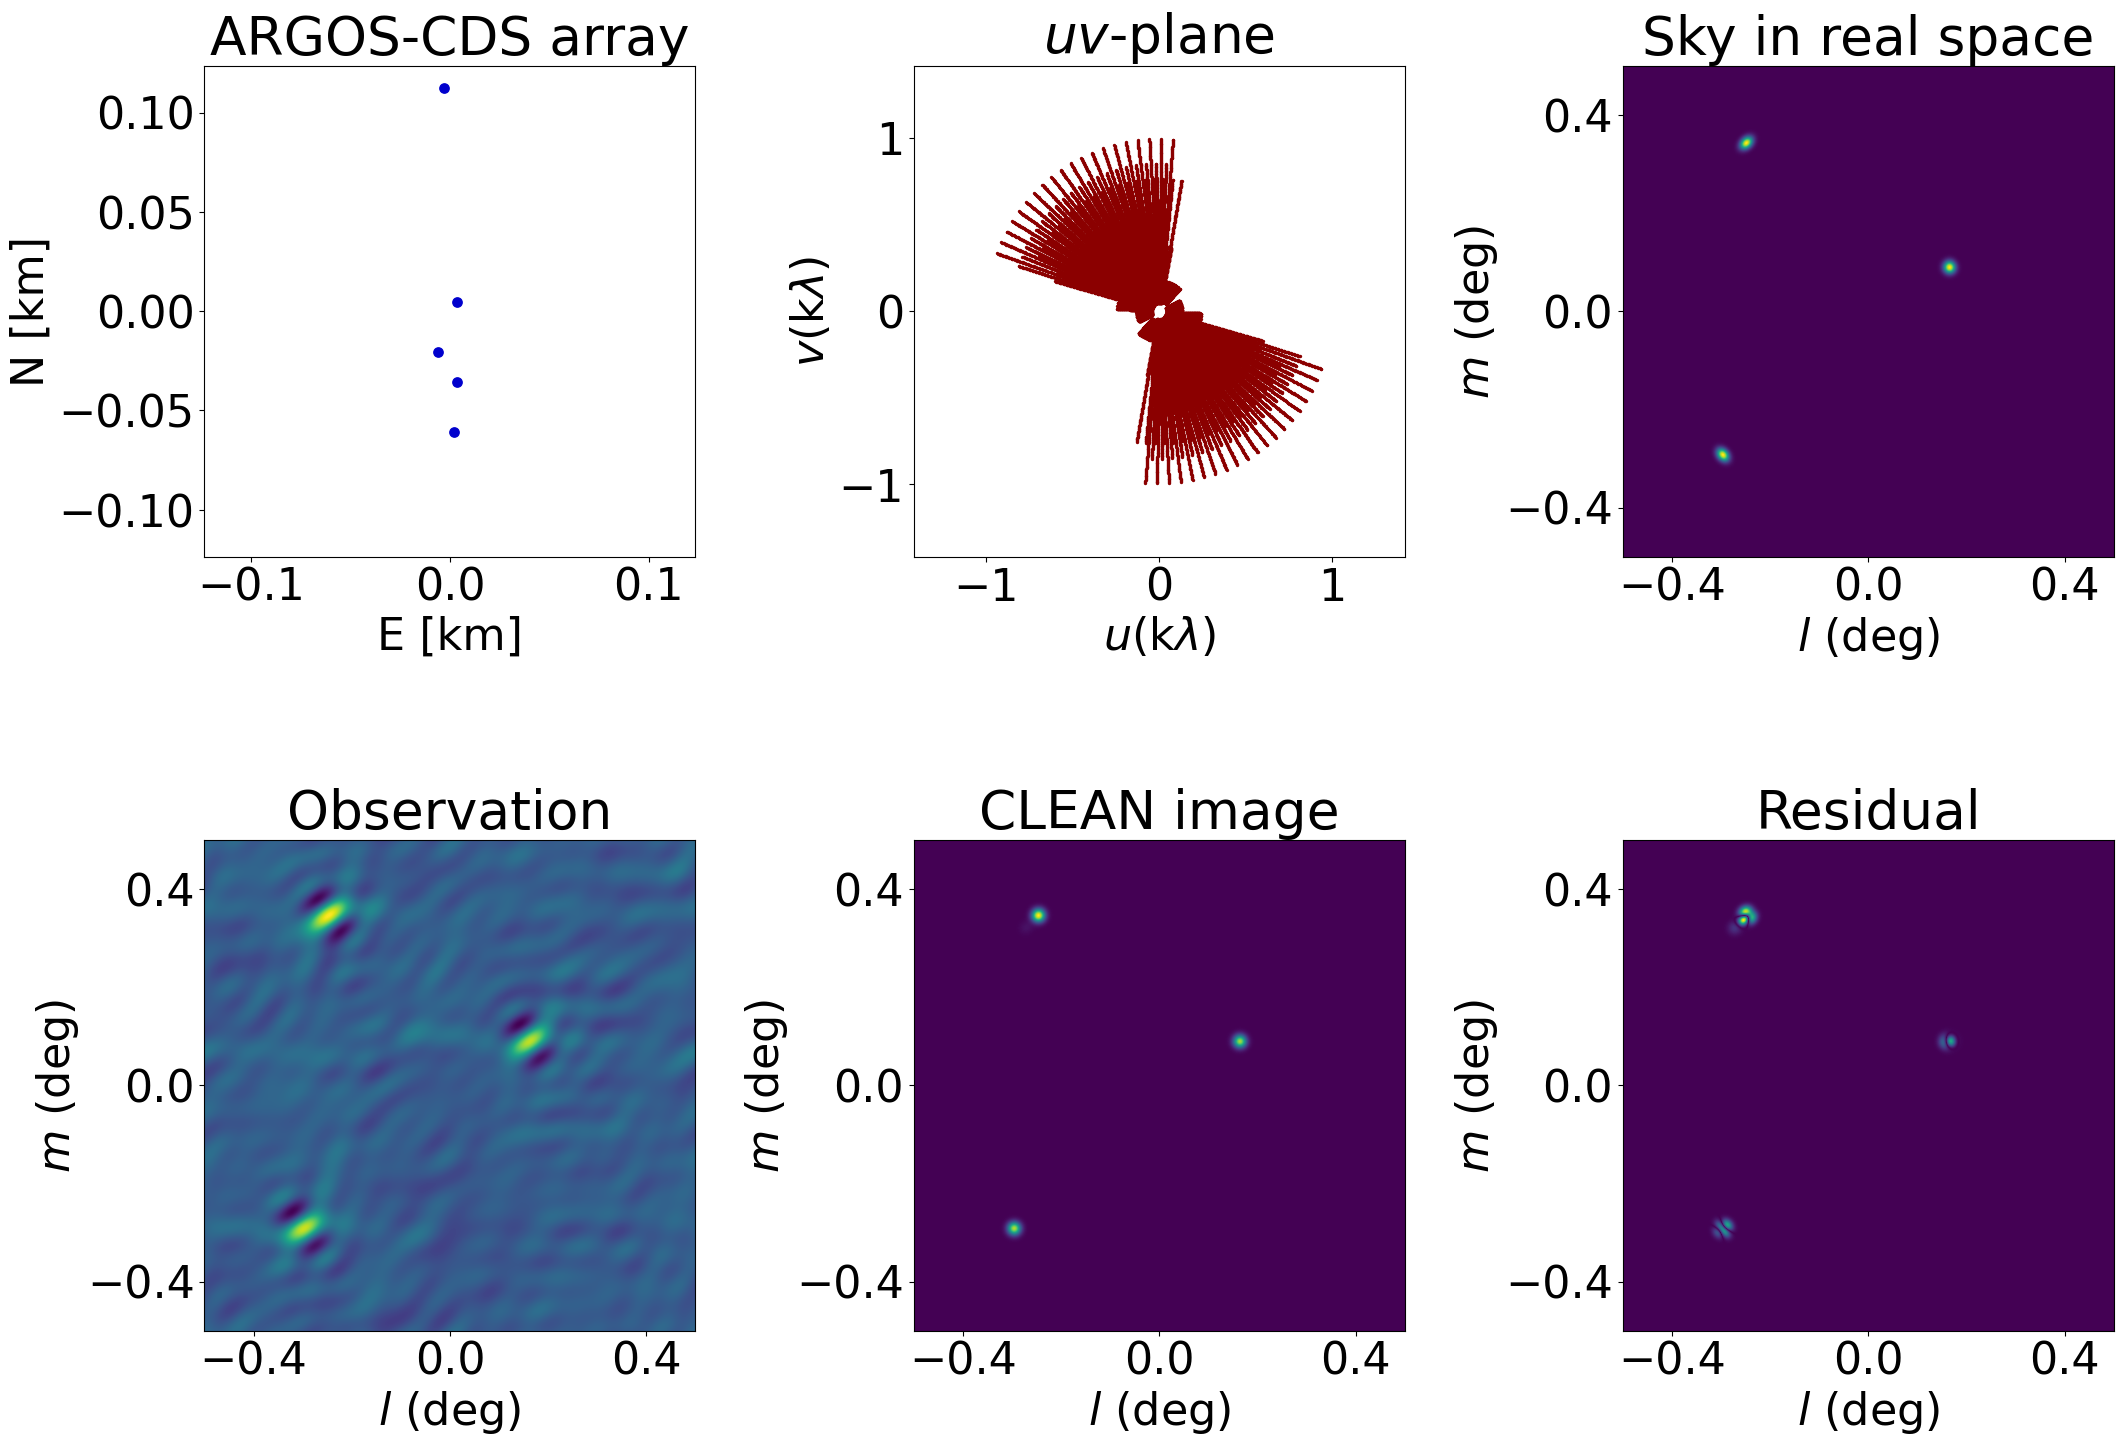

In [173]:
plt.rcParams.update({'font.size': 32})

fig, ax = plt.subplots(2,3, figsize=(22, 16))
ax = ax.flatten()
plot_antenna_arr_(antenna, ax=ax[0], fig=fig, title='ARGOS-CDS array')
plot_baselines_(track, ax=ax[1], fig=fig)

ax[2].imshow(np.abs(sky), extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[2].set_xlabel(r"$l$ (deg)")
ax[2].set_ylabel(r"$m$ (deg)")
ax[2].set_title("Sky in real space")
ax[2].set_yticks([-0.4, 0, 0.4])
ax[2].set_xticks([-0.4, 0, 0.4])
ax[3].imshow(observation_single, extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[3].set_xlabel(r"$l$ (deg)")
ax[3].set_ylabel(r"$m$ (deg)")
ax[3].set_title("Observation")
ax[3].set_yticks([-0.4, 0, 0.4])
ax[3].set_xticks([-0.4, 0, 0.4])
ax[4].imshow(I_clean_single, extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[4].set_xlabel(r"$l$ (deg)")
ax[4].set_ylabel(r"$m$ (deg)")
ax[4].set_title("CLEAN image")
ax[4].set_yticks([-0.4, 0, 0.4])
ax[4].set_xticks([-0.4, 0, 0.4])
ax[5].imshow(metrics_single['residual'], extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[5].set_xlabel(r"$l$ (deg)")
ax[5].set_ylabel(r"$m$ (deg)")
ax[5].set_title("Residual")
ax[5].set_yticks([-0.4, 0, 0.4])
ax[5].set_xticks([-0.4, 0, 0.4])
plt.tight_layout()
#plt.subplots_adjust(wspace=0.25)
#plt.savefig('../figures/argos_CDS_application.pdf',dpi=300,bbox_inches='tight')
plt.savefig('../figures/argos_CDS_application.png',bbox_inches='tight')